# Evolving Ensembles in Multi-objective GeneticProgramming for Classification with Unbalanced Data

### Dataset YEAST

Minority class = 'MIT'

Majority class = other tags

In [1]:
# Python 3.8.3
import deap # 1.3.1
from deap import gp, creator, base, tools, algorithms

import numpy as np # 1.18.5

import operator, random

import matplotlib.pyplot as plt

### Parameters

In [2]:
PNUM = 20 # Number of individuals in a population
GNUM = 10 # Number of generations
MTC = 0.2 # Mutation chance
CSC = 0.5 # Crossover chance

ATR_DATA = 8 #Data set atributes

#### Helper functions for primitive operators

In [3]:

# Protected division
def div(x, y):
    return x/y if y else 0

# If then operator - changed the name from 'if_then' to 'lf' because of cxSemantic method
def lf(a, b, c):
    return b if (a < 0) else c


#### Importing dataset

In [4]:
filename = "./Datasets/yeast.data"

with open(filename) as f:
    content = f.read().splitlines()
    
data = [] # data for saving the features from file
names = [] # names of the protein classes
    
for line in content:
    tmp = line.split()
    tmp.pop(0) # pops the first element - we dont need it
    
    names.append(tmp.pop()) # pops the last element - name of protein
    
    data.append(np.asarray(tmp, float)) # extracting features to data as float values

#### Creating a primitive set for the classificator expression

In [5]:
pset = gp.PrimitiveSet("main", arity=ATR_DATA)

# Adding primitive operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2) 
pset.addPrimitive(lf, 3, name="lf") # Added 'lf' as a name for the function


# Generate an expression where each leaf has the same depth between min and max.
expr = gp.genHalfAndHalf(pset, min_=1, max_=8) # Create expression of max depth 8 (from paper)
tree = gp.PrimitiveTree(expr) # Create tree classificator from expression

### Creating a fitness function and an individual (Generation of Tree Individuals)

In [6]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0)) #FitnessMax, Multi, Min?

# Create an individual of type primitive tree and our fitness function, pset is a previously defined
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax, pset=pset)

### Helper function for evaluation

In [7]:
# Evaluation function
def evaluateAccuracy(individual, data, names, pset): # po predlosku
    
    #Compiling the expression
    classificator = gp.compile(individual, pset)
    
    minority_count = names.count("MIT")
    true_positive_count = 0
    
    majority_count = len(names) - minority_count
    true_negative_count = 0
    
    for (d, n) in zip(data, names):
        # feeding data to individual classificator
        result = classificator(*d)        
        #counting right answers
        if (n=="MIT") and (result >= 0): true_positive_count += 1
        elif (n!="MIT") and (result < 0): true_negative_count += 1
        
    # return accuracy on minority class and majority class
    return (true_positive_count/minority_count, true_negative_count/majority_count)

### Registering elements with toolbox

In [8]:
# Creating toolbox - https://deap.readthedocs.io/en/master/examples/gp_symbreg.html
# https://deap.readthedocs.io/en/master/tutorials/basic/part2.html
toolbox = base.Toolbox()

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=8) # genHalfAndHalf - Generate an expression with a PrimitiveSet pset. Half the time, the expression is generated with genGrow(), the other half, the expression is generated with genFull()
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr) # Register individual from expression

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register('evaluate', evaluateAccuracy, data=data, names=names, pset=pset)


# Register mate function
toolbox.register('mate', gp.cxOnePoint)
#toolbox.register('mate', gp.cxSemantic, pset=pset, min=1, max=8)

#Register mutate function
toolbox.register('mutate', gp.mutNodeReplacement, pset=pset)
#toolbox.register('mutate', gp.mutSemantic, pset=pset, min=1, max=8)

#Register select function
toolbox.register('select', tools.selSPEA2)
#toolbox.register('select', tools.selNSGA2)

#toolbox.register('select', tools.selTournament, tournsize = 7) 



#### Some possible needed funcions

In [9]:
##DRAWING THE TREE###
#expr = toolbox.individual()
#nodes, edges, labels = gp.graph(expr)

### Graphviz Section ###
#import pygraphviz as pgv

#g = pgv.AGraph()
#g.add_nodes_from(nodes)
#g.add_edges_from(edges)
#g.layout(prog="dot")

#for i in nodes:
#    n = g.get_node(i)
#    n.attr["label"] = labels[i]

#g.draw("tree.pdf")

In [10]:
#DECORATE - we decorate the mate and mutate method to limit the height of generated individuals. 
#This is done to avoid an important draw back of genetic programming : bloat.

#toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
#toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))

In [11]:
#history = tools.History()

# Decorate the variation operators
#toolbox.decorate("mate", history.decorator)
#toolbox.decorate("mutate", history.decorator)

### Generating population

In [12]:
# toolbox.population(n=PNUM)

population = toolbox.population(n=PNUM)

fits = toolbox.map(toolbox.evaluate, population)
for fit, ind  in  zip(fits, population):
    ind.fitness.values = fit

#history.update(population)

### Setting stats and pareto front variable

In [13]:
pf = tools.ParetoFront() #pareto front

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


### Evolving the population 

In [14]:
#za sve vrijednosti
xvalues = []
yvalues = []
#za posljednju generaciju 
x_lastGen = []
y_lastGen = []

##DIVA-PORTAL##
for gen in range(GNUM):
    #offspring = algorithms.varOr(population, toolbox, lambda_=PNUM, cxpb=CSC, mutpb=MTC)//nije potreban varOr - bolji VarAnd algoritam
    offspring = algorithms.varAnd(population, toolbox, cxpb=CSC, mutpb=MTC)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
        
        xvalues.append(ind.fitness.values[0])
        yvalues.append(ind.fitness.values[1])
        
        if (gen == GNUM-1):
            x_lastGen.append(ind.fitness.values[0])
            y_lastGen.append(ind.fitness.values[1])
    
    population = toolbox.select(offspring + population, k=PNUM)
    pf.update(population)

#https://deap.readthedocs.io/en/master/examples/nsga3.html?highlight=toolbox.map#evolution

# algoritam od prije -->
# algorithms.eaSimple(population, toolbox, cxpb=CSC, mutpb=MTC, ngen=GNUM, stats=stats, halloffame=hof)
# log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=7, stats=stats, halloffame=hof)

### Printing and ploting the results

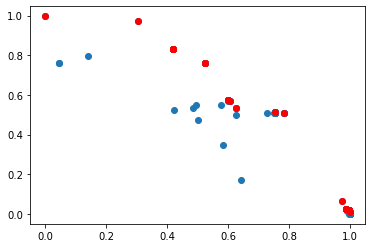

In [15]:
#zapisuje fitness vrijednosti od pareto fronte
px = []
py = []
for p in pf: 
    px.append(p.fitness.values[0])
    py.append(p.fitness.values[1])

#########koristimo već pareto frontu pa ovo nije potrebno
# pf = tools.sortLogNondominated(population,10, True)

# for p in pf:
#     px.append(p.fitness.values[0])
#     py.append(p.fitness.values[1])
###############
    
# plotamo sve fitness vrijednosti i vrijednosti pareto fronte
plt.plot(xvalues, yvalues, 'o') #sve vrijednosti (plava boja)
#plt.plot(x_lastGen, y_lastGen, 'og') #vrijednosti zadnje generacije (zelena boja)
plt.plot(px, py, 'or') #pareto fronta (crvena boja)
plt.show()



In [16]:
#import matplotlib.pyplot as plt
#import networkx

# The History class helps to build a genealogy of all the individuals produced in the evolution. 
# It contains two attributes, the genealogy_tree that is a dictionary of lists indexed by individual, 
# the list contain the indices of the parents. The second attribute genealogy_history contains every 
# individual indexed by their individual number as in the genealogy tree.

#graph = networkx.DiGraph(history.genealogy_tree)
#graph = graph.reverse()     # Make the graph top-down
#colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
#networkx.draw(graph, node_color=colors)
#plt.show()

In [ ]:
# xvalues = []
# yvalues = []

# pf = tools.ParetoFront() # Pareto front

# fits = toolbox.map(toolbox.evaluate, population)
# for fit, ind  in  zip(fits, population):
#     ind.fitness.values = fit

# for gen in range(GNUM):
#     offspring = algorithms.varAnd(population, toolbox, cxpb=CSC, mutpb=MTC)
    
#     fits = toolbox.map(toolbox.evaluate, offspring)
#     for fit, ind in zip(fits, offspring):
#         ind.fitness.values = fit
        
#         xvalues.append(ind.fitness.values[0])
#         yvalues.append(ind.fitness.values[1])
    
#     population = toolbox.select(offspring + population, k=PNUM)
    
#     pf.update(population)